# TM10007 Assignment template

In [394]:
# Run this to use from colab environment
!git clone https://github.com/Doesjka/TM10007_ML_g9.git

fatal: destination path 'TM10007_ML_g9' already exists and is not an empty directory.


## Import packages

In [395]:
import os
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import decomposition
from sklearn import metrics
from sklearn.metrics import make_scorer, accuracy_score, recall_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.utils.fixes import loguniform
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, f_classif

import seaborn
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import randint


# Define functions

## Data loading

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [396]:
def load_data():
    data = pd.read_csv('/content/TM10007_ML_g9/worclipo/Lipo_radiomicFeatures.csv', index_col=0)
    print(f'The number of features: {len(data.columns)}')
    print(f'The number of samples: {len(data.index)}')
    data_punten = len(data.index) * len(data.columns)
    ls = (data['label'] == 'liposarcoma').sum()
    print(f'Of these samples {ls} are liposarcomas. That is {round(ls/len(data.index)*100)} percent.')
    return data

## Splitting data in train and test set


In [397]:
def split1(data):
    y = data['label']

    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(y)
    y = y.flatten()

    X = data.drop('label', axis=1)

    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

## Normaal verdeling en Variantie

### Normaal verdeling
Hieronder berekenen we hoe veel van de features normaal verdeeld zijn

In [398]:
def normaal_verdeeld(X_train):
    aantal_normaal = 0

    for column in X_train.columns:
        result = stats.shapiro(X_train[column])
        normaal = result.pvalue > 0.05
        aantal_normaal += normaal

    print(aantal_normaal, " features zijn normaal verdeeld.")
    print("")

### Variantie

In [399]:
def variantie(X_train):
    variantie = X_train.var(axis=0)
    variantie = variantie.sort_values()
    # Haal features met variantie van 0 eruit, want die zeggen dus helemaal niks
    zero_variance = variantie.keys()[variantie==0]
    X_train = X_train.drop(zero_variance, axis=1)
    print(f"{len(zero_variance)} features have a variance of zero. These features are deleted.")
    print("")
    return X_train

## Handling missing data 

### Throwing out features
All features that exist of at least 50% zeros are deleted from the data. 

In [400]:
def zeros_features(X_train):
    zeros = (X_train == 0).sum()
    threshold = 0.5 * len(y_train)
    feature_del = zeros[zeros > threshold]

    X_train = X_train.drop(columns=feature_del.index)
    print(f'For {len(data.columns)-len(X_train.columns)-len(zero_variance)} features the data consisted of more than 50% zeros. These features are deleted.')

    more_zeros = (X_train == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index
    print(f'Of the remaining features, {len(columns_zeros)} features have at least one zero')
    print(f'There is a total of {more_zeros.sum()} zeros left in the data')
    print("")

    return X_train

### Calculate number of missing values per sample

In [401]:
def zeros_samples(X_train):
    zeros_r = (X_train == 0).sum(axis=1)
    threshold = 0.5 * X_train.size / len(y_train)
    sample_del = zeros_r[zeros_r > threshold]
    X_train_new = X_train.drop(index=sample_del.index)

    print(f'For {len(X_train.index)-len(X_train_new.index)} samples the data consisted of more than 50% zeros. These samples are deleted.')
    more_zeros = (X_train == 0).sum()
    print(f'There is a total of {more_zeros.sum()} zeros left in the data')
    print("")
    return X_train_new

### Filling remaining zeros
All remaining zeros are replaced by the median of that feature. 

In [402]:
def fill_zeros_median(X_train):
    more_zeros = (X_train == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index

    for column in columns_zeros[:]:
        column_median = X_train.loc[X_train[column]!=0, column].median()
        X_train[column].replace(0, column_median)
        
    return X_train

def fill_zeros_mean(X_train):
    more_zeros = (X_train == 0).sum()
    columns_zeros = more_zeros[more_zeros > 0].index

    for column in columns_zeros[:]:
        column_mean = X_train.loc[X_train[column]!=0, column].mean()
        X_train[column].replace(0, column_mean)

    return X_train

## Outliers eruit halen


In [403]:
def outliers(X_train):

    outliers_total = 0

    for column in X_train.columns:
        q1 = X_train[column].quantile(0.25)
        q3 = X_train[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)

        outliers_column = (X_train[column] < lower_bound).sum() + (X_train[column] > upper_bound).sum()
        outliers_total += outliers_column

        X_train.loc[X_train[column] < lower_bound, column] = lower_bound
        X_train.loc[X_train[column] > upper_bound, column] = upper_bound

    print(f"Er zijn {outliers_total} outliers vervangen.")
    print(f"Dit was {round(outliers_total / data_punten *100)}% van het totale aantal datapunten.")
    print("")
    return X_train

## Scaling

In [404]:
def scaling(X_train):
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    return X_train_scaled_df

## ANOVA

In [405]:
# ANOVA feature selection for numeric input and categorical output

def anova_feature_selection(X_train_scaled_df):
    fs = SelectKBest(score_func=f_classif, k='all')

    fit = fs.fit(X_train_scaled_df, y_train)
    fit = fit.pvalues_
    df = pd.DataFrame(fit, columns=['P-value'], index=X_train_scaled_df.columns)
    rslt_df = df[df['P-value'] <= 0.05]
    transpose = X_train_scaled_df.transpose()
    new_df= rslt_df.join(transpose, how='left')
    new_df = new_df.transpose()
    X_train_ANOVA = new_df.drop('P-value', axis=0)
    return X_train_ANOVA

## PCA

In [406]:
def principle_components(X_train_ANOVA):
    pca = decomposition.PCA()
    pca.fit(X_train_ANOVA)
    X_pca = pca.transform(X_train_ANOVA)

    component = 0
    total_ratio = 0
    while total_ratio < 0.95:
        total_ratio += pca.explained_variance_ratio_[component]
        component+=1

    component2=0
    grens = 0.0005
    while pca.explained_variance_ratio_[component2] > grens:
        component2+=1

    print("95 procent van de explained variance ratio geeft",component, "componenten. Dit is wat we nu gebruiken")
    print(f"Het laatste component dat meer dan {grens} bijdraagt aan de explained variance is {component2}")
    print("")
    X_pca = X_pca[:,0:component]
    return X_pca


## Create custom scoring

In [407]:
def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    score = 2 * accuracy * recall / (accuracy + recall)
    return score

## Linear Classification

In [408]:
def LDA(X_pca,y_train,clsfs):
    print("Working on the linear classification")
    LDA_classifier = LinearDiscriminantAnalysis()
    LDA_classifier.fit(X_pca, y_train)
    clsfs.append(LDA_classifier)
    print("")
    return clsfs

## Quadratic Discriminant Analysis

In [409]:
def QDA(X_pca, y_train, clsfs):
    print("Working on the quadratic classification")
    # set parameters
    parameters = {'reg_param': np.arange(0, 1, 0.1)}

    # Specify the cross validation method to use, we use 10-fold stratified cross-validation
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)

    # Create QDA object
    qda = model_selection.RandomizedSearchCV(QuadraticDiscriminantAnalysis(), parameters, n_iter=11,
                                    cv=cv_10fold, scoring=scoring)

    # Do the search
    qda.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    qda_df = pd.DataFrame(qda.cv_results_)
    # display(qda_df)

    # Extract the best hyperparameters and fit
    QDA_classifier = qda.best_estimator_
    QDA_classifier.fit(X_pca, y_train)
    clsfs.append(QDA_classifier)
    print("")
    return clsfs

## k-NN

In [425]:
def KNN(X_pca, y_train, clsfs):
    print("Working on the KNN classification")
    # Specify the search range, this could be multiple parameters for more complex classifiers
    parameters = {'n_neighbors': randint(1, 10),
                'weights': ['uniform','distance'],
                'p': randint(1, 5),
                'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                'leaf_size': [2, 4, 10, 30]}

    # Specify the cross validation method to use, we use 10-fold stratified cross-validation
    cv_6fold = model_selection.StratifiedKFold(n_splits=6)

    # Create the grid search method, use area under ROC curve as scoring metric
    # Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    clf = model_selection.RandomizedSearchCV(neighbors.KNeighborsClassifier(), parameters, cv=cv_6fold, n_iter=500, scoring=scoring)

    # Do the entire search
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    # print(clf_df)

    # Extract the best k 
    clf_df = clf_df.sort_values(by=['rank_test_score'])
    # optimal_k = clf_df['param_n_neighbors'].iloc[0]
    print(clf.best_params_)
    print(clf.best_score_)

    # Extract the best hyperparameters and fit
    knn_classifier = clf.best_estimator_
    knn_classifier.fit(X_pca, y_train)
    clsfs.append(knn_classifier)
    print("")
    return clsfs

## Random Forest

In [411]:
def RF(X_pca, y_train, clsfs):
    print("Working on the Random Forest classification")
    parameters = {'n_estimators': np.arange(50, 400, 50),
                'max_depth': [5, 10, 15],
                'min_samples_leaf': [2, 4]}

    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    # print(scoring)
    clf = model_selection.RandomizedSearchCV(RandomForestClassifier(), parameters, cv=cv_10fold, n_iter=40, scoring=scoring)
        
    # Fit the classifier
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    clf_df = clf_df.sort_values(by=['rank_test_score'])

    # Extract the best hyperparameters 
    print(clf.best_params_)
    print(clf.best_score_)

    # Extract the best hyperparameters and fit
    RF_classifier = clf.best_estimator_
    RF_classifier.fit(X_pca, y_train)
    clsfs.append(RF_classifier)
    print("")
    return clsfs


## SVM

In [412]:
def SVM(X_pca, y_train, clsfs):
    print("Working on the SVM classification")

    parameters = {'C': loguniform(0.1, 100),
                'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                'degree': randint(1, 5),
                'gamma': loguniform(1e-4, 1e-3),
                'class_weight':['balanced', None]}
    
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)

    clf = model_selection.RandomizedSearchCV(SVC(), parameters, cv=cv_10fold, n_iter=500, scoring=scoring)

    # Do the entire search
    clf.fit(X_pca, y_train)

    # Show the complete results of the cross validation
    clf_df = pd.DataFrame(clf.cv_results_)
    clf_df = clf_df.sort_values(by=['rank_test_score'])

    # Extract the best hyperparameters 
    print(clf.best_score_)
    print(clf.best_params_)

    # Extract the best hyperparameters and fit
    svm_classifier = clf.best_estimator_
    svm_classifier.fit(X_pca, y_train)
    clsfs.append(svm_classifier)
    print("")
    return clsfs

## Learning curves

In [414]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        model_selection.learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

def plot_all_curves(X_train):
    fig = plt.figure(figsize=(24,10))
    num = 0
    for clf in clsfs:
        num +=1
        ax = fig.add_subplot(2, 3, num)
        title = str(type(clf))
        plot_learning_curve(clf, title, X_train, y_train, ax, ylim=(0.3, 1.01), cv=10)

# Using the functions

## Training

The number of features: 494
The number of samples: 115
Of these samples 58 are liposarcomas. That is 50 percent.
Voor nu zijn we alleen nog aan het testen
88  features zijn normaal verdeeld.

21 features have a variance of zero. These features are deleted.

For 32 features the data consisted of more than 50% zeros. These features are deleted.
Of the remaining features, 10 features have at least one zero
There is a total of 44 zeros left in the data

For 0 samples the data consisted of more than 50% zeros. These samples are deleted.
There is a total of 44 zeros left in the data

Er zijn 2037 outliers vervangen.
Dit was 4% van het totale aantal datapunten.

95 procent van de explained variance ratio geeft 17 componenten. Dit is wat we nu gebruiken
Het laatste component dat meer dan 0.0005 bijdraagt aan de explained variance is 39

Working on the KNN classification
{'algorithm': 'kd_tree', 'leaf_size': 10, 'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
0.7676447968998885

Working on the

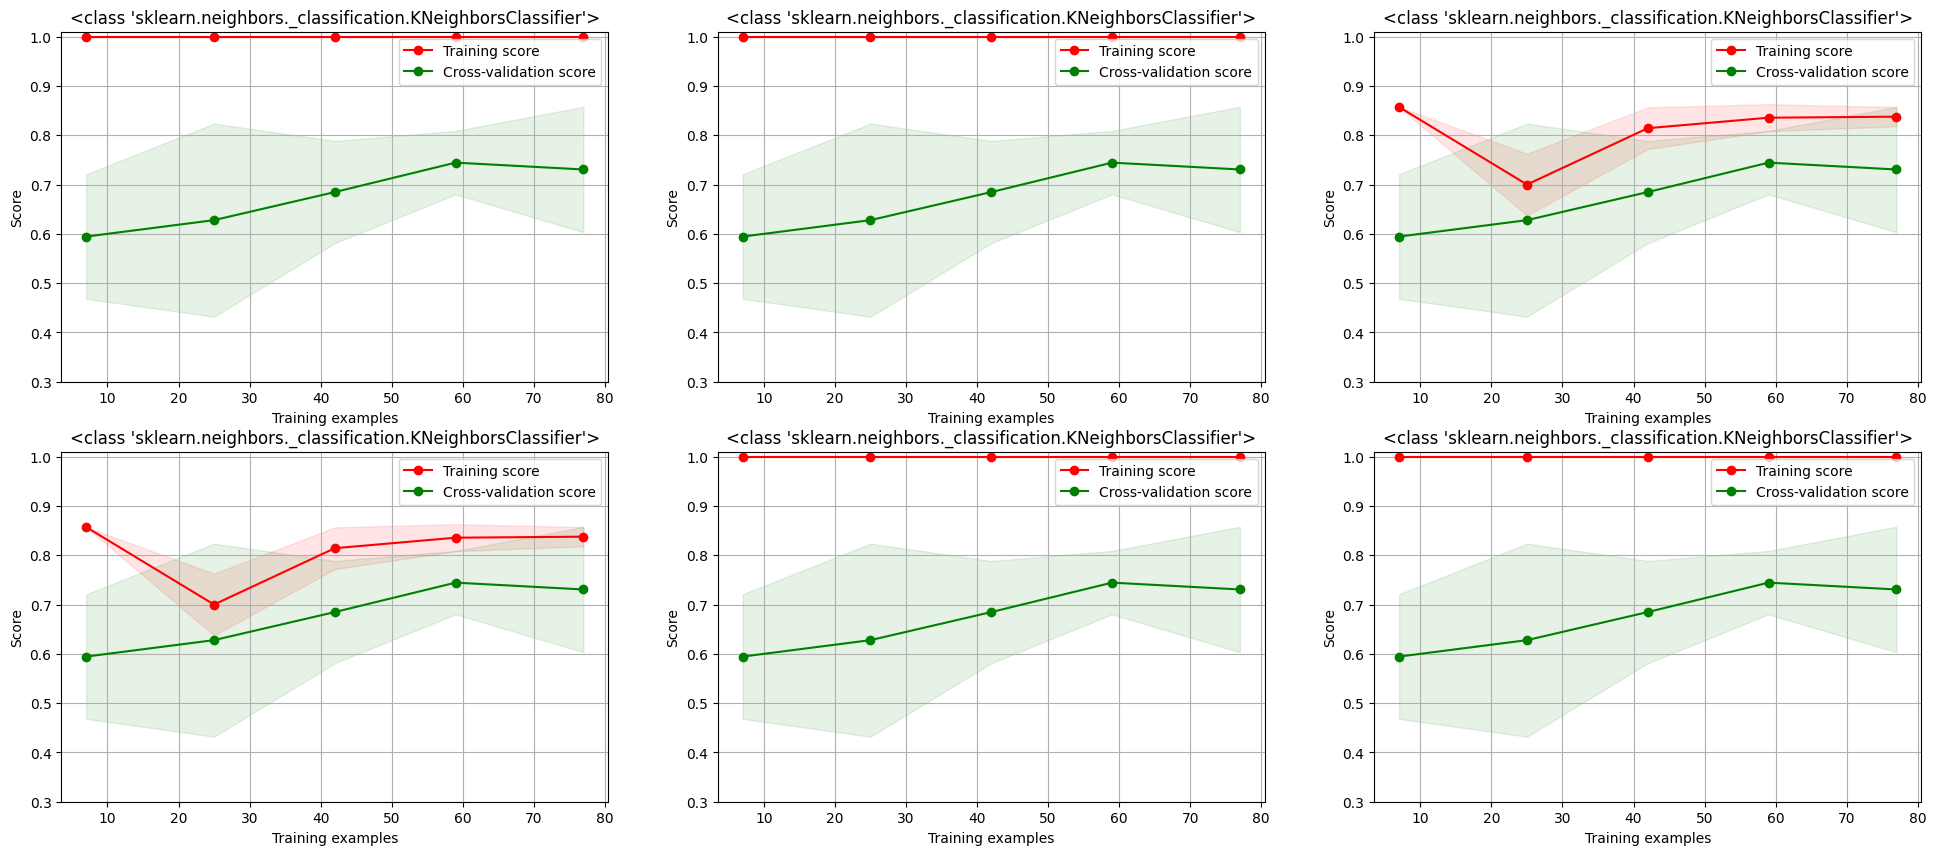

In [426]:
import warnings
warnings.filterwarnings("ignore")

# Load data
data = load_data()

# Split data
X_train, X_test, y_train, y_test = split1(data)

# Kondig aan bij welke fold we zijn
print('Voor nu zijn we alleen nog aan het testen')

# Test hoe veel van de features normaal verdeeld zijn.
normaal_verdeeld(X_train)

# Bepaal de variantie en gooi features eruit die een variantie van nul hebben.
X_train = variantie(X_train)

# Features en samples met te veel nullen eruit gooien
X_train = zeros_features(X_train)
X_train = zeros_samples(X_train)

# Remove outliers
X_train = outliers(X_train)

# Scaling
X_train = scaling(X_train)

# Anova feature selection
X_train = anova_feature_selection(X_train)

# PCA
X_train = principle_components(X_train)

# Initiate classifications
clsfs = list()
scoring = make_scorer(custom_score)

# Classifiers
# clsfs = LDA(X_train,y_train,clsfs)
# clsfs = QDA(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
clsfs = KNN(X_train,y_train,clsfs)
# clsfs = RF(X_train, y_train, clsfs)
# clsfs = SVM(X_train, y_train, clsfs)

# Plot learning curves
plot_all_curves(X_train)
